# **Asian Jim Detector**

One of my all time favourite TV shows is 'The Office' (US version obviously) so following Lesson 1 of the [Fast AI Practical Deep Learning for Coders course](http://https://course.fast.ai/) taught by Jeremy Howard I've decided to create a  Asian Jim (Randall Park) Detector referring to the [Asian Jim Scene](http://www.youtube.com/watch?v=cLNyF1Zw5tg)

This notebook is based of the [Is it a bird notebook](http://https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) shared in lesson one.

## Step 1: Download Images of both Jim's

The actor who plays Jim Halpert in the show is John Krasinski wheras Randall Park plays Asian Jim.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('Randall Park', max_images=1)
urls[0]

Searching for 'Randall Park'


'https://ourculturemag.com/wp-content/uploads/2017/07/MV5BN2JjMzMyMTgtZmUzNy00OTExLTljYjYtZGIwMmQzYTdiZTUzXkEyXkFqcGdeQXVyMjQwMDg0Ng@@._V1_SY1000_CR006981000_AL_-696x997.jpg'

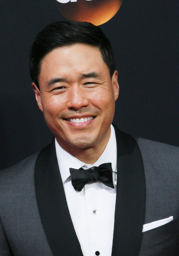

In [4]:
from fastdownload import download_url
dest = 'randallpark.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [5]:
urls = search_images('John Krasinski', max_images=1)
urls[0]

Searching for 'John Krasinski'


'https://arc-anglerfish-arc2-prod-bostonglobe.s3.amazonaws.com/public/U77JV2ZHEGQ4M2X4FDYZ5OTRWI.jpg'

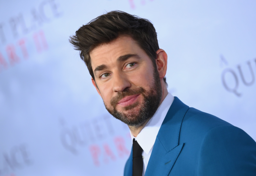

In [6]:
from fastdownload import download_url
dest = 'johnkrasinski.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Grab example photos of both Jims, intentionally not picking office related photos as there won't be sufficient photos of Randall Park.

In [7]:
searches = 'Randall Park','John Krasinski'
path = Path('asianJimDetector')

search_dict={
    'Randall Park': 'Asian Jim',
    'John Krasinski':'Jim'
}

from time import sleep

for key in search_dict.keys():
    dest = (path/search_dict[key])
    print(f'Photos are being stored in the following directory:\t{dest}')
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{key} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{key} movie photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{key} actor black and white photo'))
    sleep(10)
    resize_images(path/search_dict[key], max_size=400, dest=path/search_dict[key])

Photos are being stored in the following directory:	asianJimDetector/Asian Jim
Searching for 'Randall Park photo'
Searching for 'Randall Park movie photo'
Searching for 'Randall Park actor black and white photo'
Photos are being stored in the following directory:	asianJimDetector/Jim
Searching for 'John Krasinski photo'
Searching for 'John Krasinski movie photo'
Searching for 'John Krasinski actor black and white photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

## Step 2: Train Model

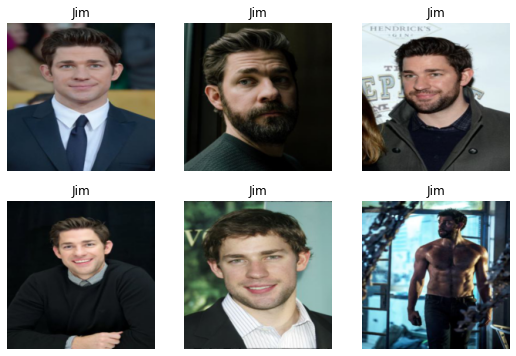

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Train a resnet18 model:

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10) # Run for 10 epochs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.327693,2.394001,0.484848,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.724184,1.058095,0.424242,00:01
1,0.468597,0.308925,0.090909,00:01
2,0.357362,0.197184,0.090909,00:01
3,0.285853,0.166184,0.090909,00:01
4,0.223101,0.153807,0.090909,00:01
5,0.189819,0.151263,0.090909,00:01
6,0.156207,0.153573,0.090909,00:01
7,0.131327,0.152724,0.090909,00:01
8,0.116661,0.154246,0.090909,00:01
9,0.100495,0.157140,0.090909,00:01


In [11]:
doc(learn.fine_tune)

Learner.fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5.0, *, lr_max=None, div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False, start_epoch=0)
Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


## Use our Model

Use the model to classify the images of Jim and Asian Jim shown at the start!

In [12]:
is_asianJim,_,probs = learn.predict(PILImage.create('randallpark.jpg'))
print(f"This is a: {is_asianJim}.")
print(f"Probability it's asian Jim: {probs[0]:.4f}")

This is a: Asian Jim.
Probability it's asian Jim: 1.0000


In [13]:
is_asianJim,_,probs = learn.predict(PILImage.create('johnkrasinski.jpg'))
print(f"This is a: {is_asianJim}.")
print(f"Probability it's asian Jim: {probs[0]:.4f}")

This is a: Jim.
Probability it's asian Jim: 0.0151
